In [1]:
import json
import pickle
import numpy as np
import os
import random
import re
#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#hyperparameter tuning
from sklearn.model_selection import GridSearchCV
#preprocessing
from sklearn.preprocessing import normalize
#for stats
from scipy import stats
import time
import sys
#for plots
import matplotlib.pyplot as plt 
from sklearn.metrics import plot_confusion_matrix

In [2]:
# saving local file paths in variables
EMB_DIR = './embeddings/'
IMG_EMB_DIR = './image-embeddings/'
LIB_DIR = "./app/lib/"

In [3]:
'''prep text data:
- convert text to text embedding
- structure every sample as a row'''
def ready_text_data():
    files = [f for f in os.listdir(EMB_DIR)]
    # shuffle files in list
    random.seed(42)
    random.shuffle(files)

    # setting train size to 80% of data
    train_size = int(len(files)*0.8)

    # initializing train and target to 0 vectors/matrices
    x_train = np.zeros((train_size, 768))
    x_test = np.zeros((len(files)-train_size, 768))
    y_train = np.zeros(train_size, dtype=int)
    y_test = np.zeros(len(files)-train_size, dtype=int)

    # loop through train indices and store in x_train and y_train
    for i in range(train_size):
        filename = files[i]
        with open(EMB_DIR + filename, 'r') as f:
            x_train[i] = json.load(f)
            y_train[i] = (0 if re.match('.*neg.*', filename) else 1)

    # loop trhough test indices and store in x_test and y_test
    for i in range(len(files) - train_size):
        filename = files[train_size+i]
        with open(EMB_DIR + filename, 'r') as f:
            x_test[i] = json.load(f)
            y_test[i] = (0 if re.match('.*neg.*', filename) else 1)

    # make sure pos/neg split is correct
    print("Negative/Positive Breakdown")
    print(y_train.mean(), y_test.mean())
    return x_train, y_train, x_test, y_test

In [4]:
'''preprocess images:
- convert to image embedding
- put each observation in "tidy" data format where each row is
a sample'''
def ready_image_data():
    files = [f for f in os.listdir(IMG_EMB_DIR)]
    random.seed(42)
    random.shuffle(files)

    train_size = int(len(files)*0.8)

    x_train = np.zeros((train_size, 2048))
    x_test = np.zeros((len(files)-train_size, 2048))
    y_train = np.zeros(train_size, dtype=int)
    y_test = np.zeros(len(files)-train_size, dtype=int)

    print(f"train size: {x_train.shape[0]}")
    class_map = {}
    for i in range(train_size):
        filename = files[i]
        curr_class = filename.split('-')[0]
        if curr_class in class_map:
            y_train[i] = class_map[curr_class]
        else:
            curr_key = len(class_map) + 1
            class_map[curr_class] = curr_key
            y_train[i] = curr_key
        with open(IMG_EMB_DIR+filename, 'r') as f:
            x_train[i] = json.load(f)
    print(f"class count for train: {len(class_map)}")

    num_classes_not_in_train = 0
    print(f"test size: {x_test.shape[0]}")
    for i in range(len(files)-train_size):
        filename = files[i+train_size]
        curr_class = filename.split('-')[0]
        if curr_class in class_map:
            y_test[i] = class_map[curr_class]
        else:
            curr_key = len(class_map) + 1
            class_map[curr_class] = curr_key
            num_classes_not_in_train += 1
            y_test[i] = curr_key
        with open(IMG_EMB_DIR+filename, 'r') as f:
            x_test[i] = json.load(f)
    print(f"class count for test: {len(class_map)}")
    print(f"num classes not in train: {num_classes_not_in_train}")

    # get mode class aka the baseline for classification
    mode = stats.mode(y_train)
    print("Baseline :", 100*round(mode.count[0]/len(y_train), 2), "%")

    return x_train, y_train, x_test, y_test, class_map

In [5]:
# setting text color to white 
import matplotlib as mpl
COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

In [19]:
''' Build Logistic Regression model
that is trained and put into production predicting
the sentiment of product review text embeddings'''
def build_LR(x_train, y_train, x_test, y_test):
    x_train = normalize(x_train)
    x_test = normalize(x_test)

    # MODEL 1 - Logistic Regression
    # instantiate model
    model = LogisticRegression(max_iter=1000)
    # fit model to training data
    model.fit(x_train, y_train)
    # see resulting model's score on test data
    print("Logistic Regression TXT Score:")
    print(model.score(x_test, y_test))
    plot_confusion_matrix(model, x_test, y_test,
                                 display_labels=["Negative", "Positive"],
                                 cmap=plt.cm.Blues,
                                 values_format=".0f")
    plt.title("Text Task Confusion Matrix")
    plt.savefig('text-lr-confusion-matrix.png', facecolor='black', 
                edgecolor='none')
    plt.savefig('text-lr-confusion-matrix-trans.png', transparent=True)
    plt.show()
    

In [23]:
''' Build Random Forest model that is trained
and used to predict the class of a "natural image"'''
def build_IMG(x_train, y_train, x_test, y_test, class_map):
    x_train = normalize(x_train)
    x_test = normalize(x_test)
    # instantiate model
    model = RandomForestClassifier(min_samples_leaf=2)
    # fit model to train data
    model.fit(x_train, y_train)
    # see resulting model's score
    print("RF IMG Score:")
    print(model.score(x_test, y_test))
    plot_confusion_matrix(model, x_test, y_test,
                                 display_labels=class_map.keys(),
                                 cmap=plt.cm.Blues,
                                 values_format=".0f", 
                                 xticks_rotation="vertical")
    plt.title("Image Task Confusion Matrix")
    plt.savefig('img-rf-confusion-matrix.png', facecolor='black', edgecolor='none',
               bbox_inches='tight')
    plt.savefig('img-rf-confusion-matrix-trans.png', transparent=True, bbox_inches='tight')
    plt.show()

Negative/Positive Breakdown
0.5045185848069675 0.5027728762288883
Logistic Regression TXT Score:
0.9534408873203932


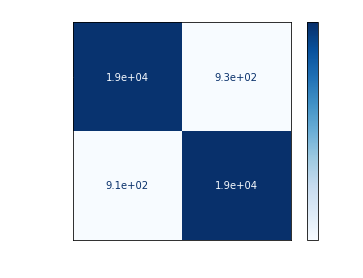

In [21]:
# building text model
x_train, y_train, x_test, y_test = ready_text_data()
build_LR(x_train, y_train, x_test, y_test)

train size: 5519
class count for train: 8
test size: 1380
class count for test: 8
num classes not in train: 0
Baseline : 14.000000000000002 %
RF IMG Score:
0.9971014492753624


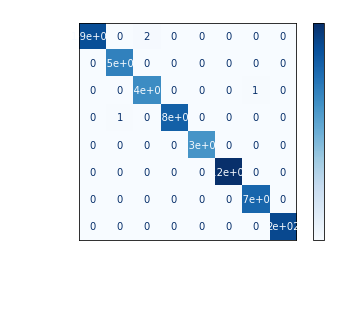

In [24]:
# building image model
X_train, Y_train, X_test, Y_test, class_map = ready_image_data()
build_IMG(X_train, Y_train, X_test, Y_test, class_map)